# Supercontinuum and second harmonic generations

## Single Envelope

Let's try Phillips equations now in the frequency domain

We begin by the typical Python imports.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import time
from scipy import fftpack as sp
import copy
from matplotlib import cm
import colorcet as cc
from matplotlib.colors import Normalize

#This are my libraries
import nlo 
import materials
import waveguides
from util import sech

## Units
We'll work in SI units. Mostly in base units.

In [2]:
from scipy.constants import pi, c, epsilon_0

## Time and Frequency domain windows

Now we need to determine an FFT size $N$, this will be the common size for the time and frequency axis in our simulations. We also need to select how large the time window $2 T_{\mathrm{max}}$ for our simulations will be. The time window needs to be large enough so that pulses don't reach the edge of the domain at any point. Since we'll usually pick a reference frame that moves with one of the pulses, then how much the other pulses travel depends on the respective group velocity mismatch. The sampling period $\Delta t$ will be determined by the size of the window and the number of points; Nyquist criteria must be satisfied as usual.

Once the number of points and time-window has been selected, the frequency grid is fixed by the FFT, with a frequency resolution
$$ F_s = \frac{1}{N \Delta t},$$
the minimum relative frequency is 0 while the maximum is
$$ BW = \frac{1}{\Delta t}.$$
The maximum relative frequency should alway be below the desired absolute carrier frequency. So the longest wavelength allowed becomes:
$$ \lambda_{\mathrm{max}} = \frac{c}{F_{\mathrm{max}}} = 2c\Delta t $$

The reference frequency $f_{ref}$ can be chosen arbitrarely, but without more information a good start point could be the geometric mean between the min and max frequencies of interest, shifted by fmin.

In [3]:
wl_max = 2.5e-6
wl_min = 0.3e-6
f_max = c/wl_min
f_min = c/wl_max
f_ref = 400e12

omega_ref = 2*pi*f_ref
wl_ref = c/f_ref
BW = f_max-f_min #This is the bandwidth desired
dt = 1/BW
NFFT = 2**13 #Number of FFT points
Twindow = dt*NFFT
print('Reference wavelength = %0.1f nm' %(wl_ref*1e9))
print('Reference frequency = %0.1f THz' %(f_ref*1e-12))
print('Min absolute frequency needed = %0.1f THz' %(f_min*1e-12))
print('Max absolute frequency needed = %0.1f THz' %(f_max*1e-12))
print('Bandwidth needed = %0.1f THz' %(BW*1e-12))
print('Time resolution needed = %0.3f fs' %(dt*1e15))
print('Maximum size of time window based on %i FFT points = %0.3f fs' %(NFFT, Twindow*1e15))
print('\n')


Twindow = 12e-12
t = np.linspace(-Twindow/2, Twindow/2, NFFT)
dt = t[1]-t[0] #Sampling period
f = fftfreq(NFFT, dt)
omega = 2*pi*f
df = f[1]-f[0]
print('Actual time window chosen = %0.3f fs' %(Twindow*1e15))
print('Actual Sampling Rate = %0.3f fs' %(dt*1e15))
print('Frequency Resolution = %0.3f THz' %(df*1e-12))
print('Minimum absolute frequency = %0.3f THz' %((np.min(f) + f_ref)*1e-12))
print('Maximum absolute frequency = %0.3f THz' %((np.max(f) + f_ref)*1e-12))

Reference wavelength = 749.5 nm
Reference frequency = 400.0 THz
Min absolute frequency needed = 119.9 THz
Max absolute frequency needed = 999.3 THz
Bandwidth needed = 879.4 THz
Time resolution needed = 1.137 fs
Maximum size of time window based on 8192 FFT points = 9315.535 fs


Actual time window chosen = 12000.000 fs
Actual Sampling Rate = 1.465 fs
Frequency Resolution = 0.083 THz
Minimum absolute frequency = 58.708 THz
Maximum absolute frequency = 741.208 THz


## Input pulse creation

Center Wavelength = 1.499 um
Center frequency = 200.000 THz
FWHM = 60.018 fs
Pulse Energy = 99.953 pJ
Pulse peak power = 1665.891 W
Comb average power = 999.535 mW


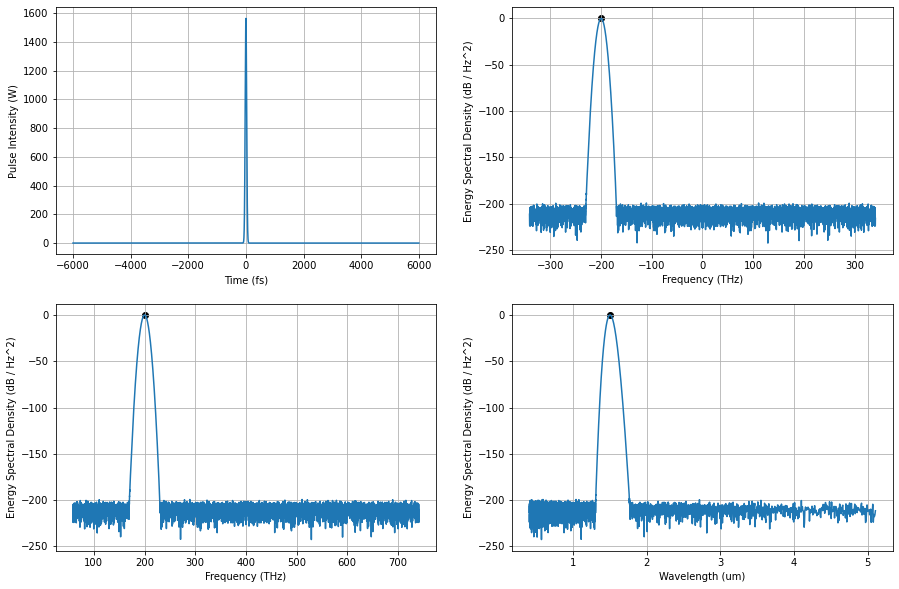

In [4]:
#Parameters
# wl0 = 1.55e-6 #center wavelength
# f0 = c/wl0
f0 = 200e12
wl0 = c/f0
delta_omega = 2*pi*(f0 - f_ref)

#get the f0 frequency index
f0_index = np.abs(f+f_ref - f0).argmin()

pulse_energy = 100e-12
tau = 60e-15 #Pulse width

#Pulse creation
frep = 10e9
pulse = np.sqrt(0.939*pulse_energy/tau)*np.exp(-2*np.log(2)*(t/tau)**2)*np.exp(1j*delta_omega*t)
noise = 1e-9*np.random.normal(size=NFFT)
pulse = pulse + noise
pulse_energy = nlo.energy_td(t, pulse) #To check that everything went well

print('Center Wavelength = %0.3f um' %(wl0*1e6))
print('Center frequency = %0.3f THz' %(f0*1e-12))
print('FWHM = %0.3f fs' %(nlo.FWHM(t, pulse)*1e15))
print('Pulse Energy = %0.3f pJ' %(pulse_energy*1e12))
print('Pulse peak power = %0.3f W' %(pulse_energy/tau))
print('Comb average power = %0.3f mW' %(pulse_energy*frep*1e3))

plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
nlo.plot_magsq(t*1e15, pulse, ax=ax1);
nlo.plot_ESD_dB(t*1e12, pulse, ax=ax2)
nlo.plot_ESD_dB_absfreq(t*1e12, pulse, f_ref*1e-12, ax=ax3)
nlo.plot_ESD_dB_vs_wavelength(t, pulse, f_ref, ax=ax4)

ax2.scatter(f[f0_index]*1e-12, 0, c='k');
ax3.scatter((f[f0_index]+f_ref)*1e-12, 0, c='k');
ax4.scatter(c/(f[f0_index]+f_ref)*1e6, 0, c='k');

## Waveguides

In [5]:
def get_waveguide_dispersion():
    #Waveguide geometry
    etch = 0.35
    hridge = 0.7
    hslab = hridge - etch
    wridge = 1.5
    
    #Effective index calculation
    neff = np.zeros(f.shape)
    for kf in range(f.size):
        freq = f[kf] + f_ref
        wl = c/freq*1e6 #Wavelength in microns

        #Material properties (frequency dependent)
        n0 = 1
        nLN = materials.refractive_index('LN_MgO_e', wl)
        nSiO2 = materials.refractive_index('SiO2', wl)

        neff[kf] = waveguides.neff_ridge(wl, nridge=nLN, nbox=nSiO2, nclad=n0, w=wridge, h=hridge, hslab=hslab)
    
    return neff

neff = get_waveguide_dispersion()

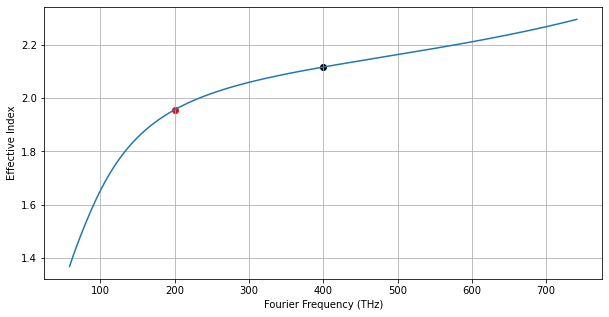

In [6]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(fftshift(f+f_ref)*1e-12, fftshift(neff));
plt.scatter((f[0]+f_ref)*1e-12, neff[0], c='k');
plt.scatter((f[f0_index]+f_ref)*1e-12, neff[f0_index], c='r');
plt.xlabel('Fourier Frequency (THz)');
plt.ylabel('Effective Index');
plt.grid(True)

The higher order dispersion operator is
$$D = \beta(\Omega) - \beta_0(\Omega=0) - \beta_1(\Omega=0) \Omega$$.

GVD at 0.749 um = 161.388 fs^2/mm
GVD at 1.499 um = -65.158 fs^2/mm
Dispersion Length for Gaussian pulse at 0.749 um = 8.045 mm
Dispersion Length for Gaussian pulse at 1.499 um = 19.927 mm
Group velocity of 1.499 um wave in moving reference plane = 0.003 mm/ps


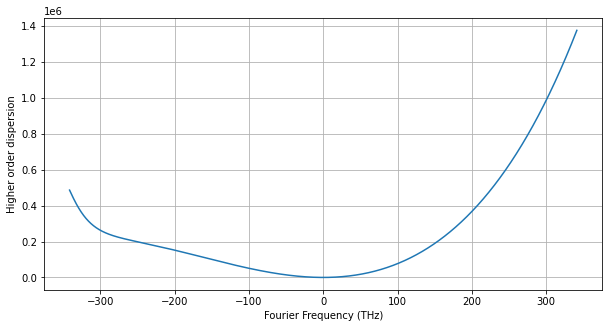

In [7]:
beta = (omega+omega_ref)*neff/c
beta_1 = np.gradient(beta, 2*pi*df)
beta_2 = np.gradient(beta_1, 2*pi*df)

beta_ref = beta[0]
beta_1_ref = beta_1[0]
D = beta - beta_ref - beta_1_ref*omega

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(fftshift(f)*1e-12, fftshift(D));
plt.xlabel('Fourier Frequency (THz)');
plt.grid(True)
plt.ylabel('Higher order dispersion');

#Some extra information
Ld = (tau)**2/(4*np.log(2)*abs(beta_2))
GVM = 1/beta_1[f0_index] - 1/beta_1_ref

print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl_ref*1e6, beta_2[0]*1e27))
print('GVD at %0.3f um = %0.3f fs^2/mm' %(wl0*1e6, beta_2[f0_index]*1e27))
print('Dispersion Length for Gaussian pulse at %0.3f um = %0.3f mm' %(wl_ref*1e6, Ld[0]*1e3))
print('Dispersion Length for Gaussian pulse at %0.3f um = %0.3f mm' %(wl0*1e6, Ld[f0_index]*1e3))
print('Group velocity of %0.3f um wave in moving reference plane = %0.3f mm/ps' %(wl0*1e6, GVM*1e3*1e-12))

Poling period for SHG:
$$
\Lambda = \frac{\lambda_{2\omega}}{n_{2\omega} - n_\omega}
$$

In [8]:
n2w = neff[np.abs(f+f_ref - 2*f0).argmin()]
nw = neff[np.abs(f+f_ref - f0).argmin()]
pp = (wl0/2)/(n2w-nw)
print('Poling period for SHG starting at %0.3f um is %0.3f um' %(wl0*1e6, pp*1e6))

Poling period for SHG starting at 1.499 um is 4.670 um


## Nonlinear  Stuff

In [9]:
def poling_rectangular(z, pp):
    return np.sign(np.exp(1j*z*2*pi/pp))

def chi2(z):
#     poling = poling_rectangular(z, pp)
    poling = 1
#     poling = poling_rectangular(z, 5e-6)
    return 2*d33*poling

def chi(z):
    return chi2(z)*(omega+omega_ref)/(2*gn*neff*c)

def nonlinear_operator(z, A):
    #Let's try this in the frequency domain
    a = ifft(A) #go to time domain
    phi = omega_ref*t - (beta_ref - beta_1_ref*omega_ref)*z #Time domain phase
    f1 = a*a*np.exp(1j*phi) + 2*a*np.conj(a)*np.exp(-1j*phi) #Time domain nonlinear func
    f = -1j*chi(z)*fft(f1) #Back to freq domain
    return f

In [10]:
def propagate(A, D):
    #Let's try this in the frequency domain and removing the split step
    
    A_evol = 1j*np.zeros([t.size, Nsteps+1])
    A_evol[:,0] = A #Initial value
    
    Da = np.exp(-1j*D*h)
    z = 0
    
    for kz in range(Nsteps):
        #Linear step
        A = Da*A

        #Nonlinear step
        #Runge-Kutta 4th order
        k1 = nonlinear_operator(z    , A       )
        k2 = nonlinear_operator(z+h/2, A+h*k1/2)
        k3 = nonlinear_operator(z+h/2, A+h*k2/2)
        k4 = nonlinear_operator(z+h  , A+h*k3  )

        z = z + h
        A = A + (h/6)*(k1+2*k2+2*k3+k4) 
        
        A_evol[:, kz+1] = A
    return A, A_evol

In [11]:
#Crystal parameters
L = 6e-3
h = 1e-3/50
Nsteps = int(L/h)
d33 = 20e-6
gn = 1

print('Crystal length = %0.2f mm' %(L*1e3))
print('Step size = %0.2f um' %(h*1e6))
print('Number of steps = %i' %(Nsteps))
print('Nonlinear coefficient, d33 = %0.2f pm/V' %(d33*1e12))

Crystal length = 6.00 mm
Step size = 20.00 um
Number of steps = 300
Nonlinear coefficient, d33 = 20000000.00 pm/V


## Single pass

In [17]:
[a, a_evol] = propagate(fft(pulse), D)

1.59 s ± 857 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
a = ifft(a)
a_evol = ifft(a_evol, axis=0)

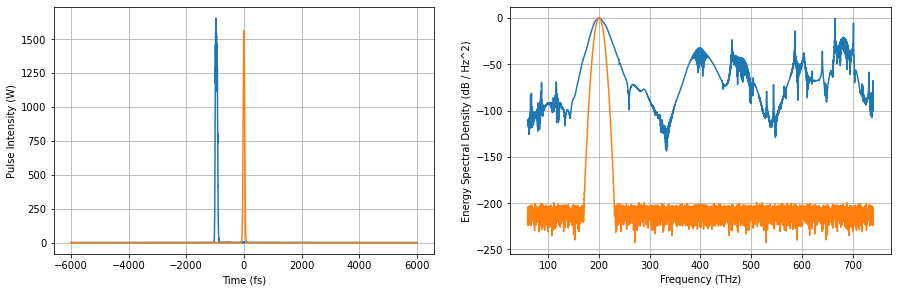

In [14]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1 = nlo.plot_magsq(t*1e15, a, ax=ax1)
ax1 = nlo.plot_magsq(t*1e15, pulse, ax=ax1)

ax2 = nlo.plot_ESD_dB_absfreq(t*1e12, a, f_ref*1e-12, ax=ax2)
ax2 = nlo.plot_ESD_dB_absfreq(t*1e12, pulse, f_ref*1e-12, ax=ax2)

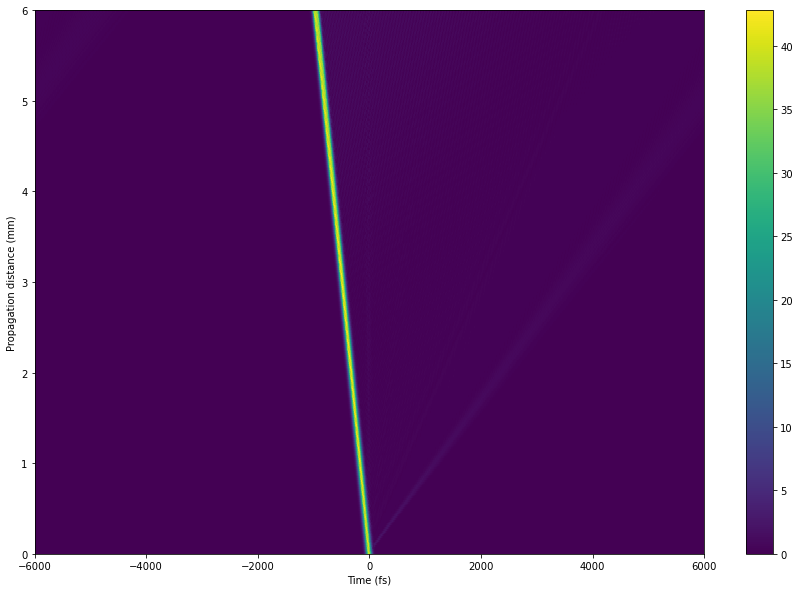

In [15]:
X,Y = np.meshgrid(t*1e15, np.arange(Nsteps+1)*h*1e3)
plt.pcolormesh(X, Y, (np.transpose(np.abs(a_evol))))
plt.xlabel('Time (fs)')
plt.ylabel('Propagation distance (mm)')
plt.colorbar()

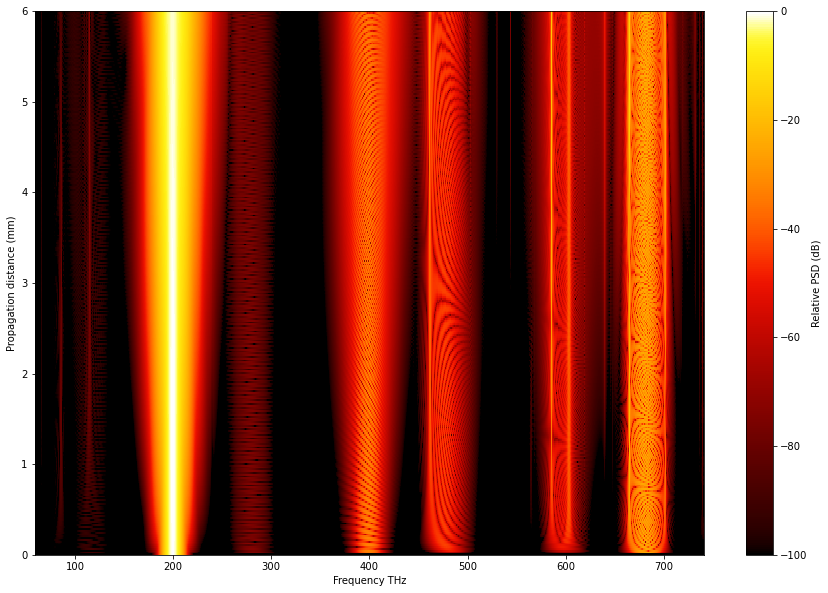

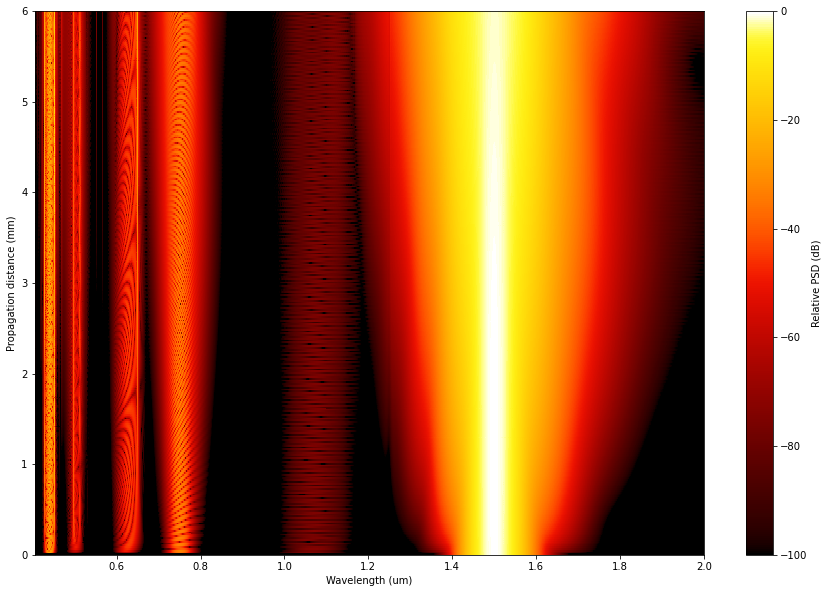

In [16]:
A_evol = np.zeros((t.size, Nsteps+1))

for k in range(Nsteps+1):
    x = a_evol[:,k]
    _ , Aesd = nlo.get_esd(t*1e15, x)
    A_evol[:,k] = 10*np.log10(Aesd)
#     A_evol[:,k] = Aesd

A_evol = A_evol - np.amax(A_evol)
A_evol = fftshift(A_evol, axes=0)

X,Y = np.meshgrid(fftshift(f+f_ref)*1e-12, np.arange(Nsteps+1)*h*1e3)
plt.figure()
plt.pcolormesh(X, Y, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-100, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Frequency THz')
plt.ylabel('Propagation distance (mm)');

wl_max = 2
wl_array = c/(fftshift(f)+f_ref)*1e6
wl_max_idx = np.abs(wl_array - wl_max).argmin()
wl_array = wl_array[wl_max_idx:]
Xwl,Ywl = np.meshgrid(wl_array, np.arange(Nsteps+1)*h*1e3)
plt.figure()
plt.pcolormesh(Xwl, Ywl, (np.transpose(A_evol[wl_max_idx:, :])), cmap = cc.cm["fire"], vmin=-100, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Wavelength (um)')
plt.ylabel('Propagation distance (mm)');